# Social-structure learning

Implementation of structure-learning model in Gershman, Pouncy, & Gweon (2017)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

from more_itertools import set_partitions
from scipy.special import gamma

In [2]:
params = {
    # 'alpha': np.linspace(10**(-5), 10, 6),  # following Sam's implementation
    # 'dalpha': np.linspace(10**(-5), 10, 6, retstep=True)[1],  # size of step between alphas
    'alpha': np.linspace(10**(-5), 3, 6),  # try a new value of alpha
    'gamma': 1,
    'M': 3,  # number of individuals,
    'N': 5,  # number of choice problems
    'X': 2,  # number of choices for each problem (can turn this into a vector later)
    'beta': 11.05  # temperature param in Luce choice rule, arbitrarily choosing 3 but this should be fit to data
}

## Prior: Chinese restaurant process

Probability of a certain grouping $\mathbf{z} = [z_1, \dots, z_m]$ (assigning each person, 1 through $m$, to a group)

$$P(\mathbf{z}|\alpha) = \frac{\alpha^K \Gamma(\alpha) \prod_k \Gamma(T_k)}{\Gamma(M+\alpha)}$$

where
- $K$ is the total number of groups
- $T_k$ is the number of individuals assigned to group $k$

Sam et al. marginalize over alphas: 
$$P(\mathbf{z}) = \int_\alpha P(\mathbf{z}|\alpha) P(\alpha) d\alpha$$

---

### Notation
- `Z`: list of all possible groupings
- `z`: a single grouping
- `PZ`: list of posterior probabilites for each grouping

In [3]:
def find_partitions(params): 
    """Return np array of all possible partitions"""
    Z = [] 
    people = [i for i in range(params['M'])]
    
    for part in set_partitions(people):
        Z.append(part)
    
    return Z

In [4]:
Z = find_partitions(params)

In [5]:
def CRP(z, params): 
    """Calculate P(z): probability for a specific grouping"""
    K = len(z)  # total number of groups
    T = np.array([len(group) for group in z])  # size of each group 
    alpha = params['alpha']

    M = params['M']  # total number of people
    
    # Calculate P(z|alpha) for all alphas
    PzGalphas = (alpha**K * gamma(alpha) * np.prod(gamma(T))) / gamma(M + alpha) 
    
    # probability of alphas is uniform over the alphas 
    Palphas = np.ones((len(alpha),)) * (1 / len(alpha)) 
    
    # marginalize over alphas
    Pz = np.sum(PzGalphas * Palphas)
    
    return Pz

In [6]:
print(Z[4])
CRP(Z[4], params)

print(Z[0])
CRP(Z[0], params)

[[0], [1], [2]]
[[0, 1, 2]]


0.36441651800803415

Find posteriors for each grouping

In [7]:
PZ = []
for z in Z:
    PZ.append(CRP(z, params))

In [8]:
# Sanity check
sum(PZ)

0.9999999999999998

In [9]:
df_PZ = pd.DataFrame(data={
    'grouping': Z, 
    'Pz': PZ
})

df_PZ['nGroups'] = df_PZ['grouping'].apply(lambda x: len(x))

In [10]:
df_PZ

,grouping,Pz,nGroups
0,"[[0, 1, 2]]",0.364417,1
1,"[[0], [1, 2]]",0.132382,2
2,"[[0, 1], [2]]",0.132382,2
3,"[[1], [0, 2]]",0.132382,2
4,"[[0], [1], [2]]",0.238438,3


Sanity check: look at distribution of group sizes

In [11]:
groupSizes = df_PZ[['Pz', 'nGroups']].groupby(by='nGroups').sum()

In [12]:
groupSizes

,Pz
nGroups,
1,0.364417
2,0.397146
3,0.238438


<AxesSubplot:xlabel='nGroups', ylabel='Pz'>

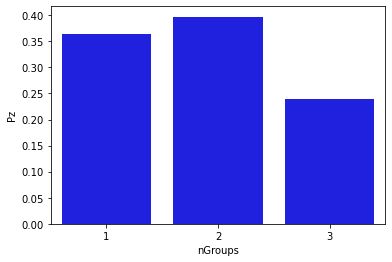

In [13]:
sns.barplot(data=groupSizes, x=groupSizes.index, y='Pz', color='blue')

## Likelihood

Given a grouping $\mathbf{z}$, the likelihood of observing choice set $\mathbf{C}$ is

$$P(\mathbf{C}|\mathbf{z}) = \prod_n \prod_k \frac{\Gamma(|\mathcal{X}_n| \gamma)}{\Gamma(T_k + |\mathcal{X}_n| \gamma)} \prod_c \frac{\Gamma(L_{kn}^c + \gamma)}{\Gamma(\gamma)}$$

where

- $|\mathcal{X}_n|$ is the number of options for problem $n$ (aka number of movies for each problem)
- $L_{kn}^c$ is the number of individuals assigned to group $k$ who chose object $c$ on problem $n$
- $T_k$, like before, is the number of individuals in group $k$

(for each $n, k$ combo, you go over all the $c$s)

Variables
- `C` is `M x N` matrix; choice matrix

In [14]:
# make some data

from numpy.random import default_rng
rng = default_rng(111)

C = np.zeros((params['M'], params['N']))

for m in range(params['M']):  # for each person
    for n in range(params['N']):  # for each problem
        C[m, n] = rng.integers(low=0, high=params['X'])  # uniformly choose among possible choices for each problem

C

array([[0., 0., 1., 0., 1.],
       [1., 0., 1., 1., 1.],
       [1., 0., 0., 1., 0.]])

In [15]:
def calc_likelihood(z, C, params):
    """
    Calculate P(C|z)
    
    here, we assume that each problem has the same number of choices (can change later)
    """
    X = np.array(params['X'])  # number of choices for each problem
    gam = params['gamma']
    K = len(z)  # total number of groups
    T = np.array([len(group) for group in z])  # size of each group 
    N = params['N']
    
#     print(X)
#     print(gam)
#     print(K)
#     print(T)
#     print(N)
    
    likSoFar = 1
    for k in range(K):  # for each group in z
        for n in range(N):  # for each problem 
            
            # update likelihood
            likSoFar *= gamma(X * gam) / gamma(T[k] + X * gam)
            
            for c in range(X):  # for each choice in each problem
                
                # Calculate L_{kn}^c
                pplInK = z[k]  # indices of individuals in group k
                C_k = np.take(C, indices=pplInK, axis=0)
                Lckn = np.sum(C_k[:, n] == c)  # L_{kn}^c

                # update likelihood
                likSoFar *= gamma(Lckn + gam) / gamma(gam)
                
    return likSoFar

In [16]:
Z[1]

[[0], [1, 2]]

In [17]:
calc_likelihood(Z[1], C, params)

3.215020576131687e-05

## Calculate posterior

In [18]:
# Remake C to something that makes sense

# 3 individuals x 5 problems

C = np.array([
    [0, 0, 0, 0, 0], 
    [1, 1, 1, 1, 1], 
    [0, 0, 0, 0, 0]
])

In [19]:
df_PZ

,grouping,Pz,nGroups
0,"[[0, 1, 2]]",0.364417,1
1,"[[0], [1, 2]]",0.132382,2
2,"[[0, 1], [2]]",0.132382,2
3,"[[1], [0, 2]]",0.132382,2
4,"[[0], [1], [2]]",0.238438,3


In [20]:
df_PZ['PCgz'] = df_PZ['grouping'].apply(lambda x: calc_likelihood(x, C, params))

In [21]:
df_PZ

,grouping,Pz,nGroups,PCgz
0,"[[0, 1, 2]]",0.364417,1,0.000004
1,"[[0], [1, 2]]",0.132382,2,0.000004
2,"[[0, 1], [2]]",0.132382,2,0.000004
3,"[[1], [0, 2]]",0.132382,2,0.000129
4,"[[0], [1], [2]]",0.238438,3,0.000031


In [22]:
# Find posterior and normalize
df_PZ['PzGC'] = df_PZ['Pz'] * df_PZ['PCgz']
df_PZ['PzGC'] = df_PZ['PzGC'] / df_PZ['PzGC'].sum()

In [23]:
df_PZ

,grouping,Pz,nGroups,PCgz,PzGC
0,"[[0, 1, 2]]",0.364417,1,0.000004,0.054586
1,"[[0], [1, 2]]",0.132382,2,0.000004,0.019829
2,"[[0, 1], [2]]",0.132382,2,0.000004,0.019829
3,"[[1], [0, 2]]",0.132382,2,0.000129,0.634541
4,"[[0], [1], [2]]",0.238438,3,0.000031,0.271214


## Putting this all together

In [24]:
def calc_posterior():  # should change this name (also calc_likelihood) to something more informative 
    pass

## Once you have the groups: choosing stuff

For each group, each choice problem has its own set $\theta$ of multinomial parameters that describe the probabilities of choosing each option. So the group you are in determines the probability of making each choice for each problem. 

Notation: $\theta_{kn}^c$ are the parameters for group $k$, problem $n$, option $c$. 

Choice matrix $\mathbf{C}$ is an $N x M$ matrix ($N$ problems, $M$ participants)

We want to find the probability that individual $m$ chooses option $c$ on an unseen problem $\mathcal{X}_\ast$: 

$$P(c_{m^\ast} = c | \mathbf{C}) = \sum_{\mathbf{z}} P(c_{m^\ast} = c | \mathbf{z}, \mathbf{C}) P(\mathbf{z} | \mathbf{C})$$

We know $P(\mathbf{z} | \mathbf{C})$, so we want to find $P(c_{m^\ast} = c | \mathbf{z}, \mathbf{C})$: 

$$P(c_{m^\ast} = c | \mathbf{z}, \mathbf{C}) = \frac{\gamma + L_{z_m^\ast}^c}{|\mathcal{X}_\ast| \gamma + \sum_{c' \in \mathcal{X}_\ast} L_{z_m^\ast}^{c'}}$$

where
- $|\mathcal{X}_\ast|$ is the number of possible choices on the unseen problem
- $L_{z_m^\ast}^c$ is the number of individuals assigned to the same group as individual $m$ who have chosen option $c$ in the new unseen problem
- $\sum_{c' \in \mathcal{X}_\ast} L_{z_m^\ast}^{c'}$ is the total number of choices that people in the same group as individual $m$ have made on the unseen problem
    - Alternatively, if each person only makes one choice (like the case we have here), it's the total number of people in the same group as individual m 

---

Example: find posteriors of what participant 2 is likely to choose for the last problem

**They should be more likely to choose option 0**

In [25]:
# add a column to C where person 2 has observed choices from person 0 and person 1 but hasn't made a choice yet
C_new = np.append(C, [[0], [1], [np.nan]], axis=1)
C_new

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0., nan]])

In [26]:
df_PZ

,grouping,Pz,nGroups,PCgz,PzGC
0,"[[0, 1, 2]]",0.364417,1,0.000004,0.054586
1,"[[0], [1, 2]]",0.132382,2,0.000004,0.019829
2,"[[0, 1], [2]]",0.132382,2,0.000004,0.019829
3,"[[1], [0, 2]]",0.132382,2,0.000129,0.634541
4,"[[0], [1], [2]]",0.238438,3,0.000031,0.271214


In [70]:
def calc_PcGzc(c, m, z, C, params): 
    """
    Calculate P(c_{m^\ast} = c | z, C)
    Assume that the last column of C is the test (unseen) problem
    
    Params: 
        c: choice index for unseen problem, between 0 and params['X'] - 1
        m: participant index
        z: list of groupings
        C: choice matrix 
    """
    gam = params['gamma']
    X = params['X']
    
    # Find indices of people in the same group as person m
    for k, group in enumerate(z): 
        if m in group:
            pplInK = z[k]
            break
    
    # Find all responses for the unseen problem for people in the same group as m
    c_ast = C[:, -1:]  # last column of C is unseen problem
    Lzm_ast = np.take(c_ast, indices=pplInK, axis=0) 
    sum_Lczm_ast = np.sum(~np.isnan(Lzm_ast)) # Total number of responses people in the same group as m gave in unseen problem
    
    # print(C)
    # print(Lzm_ast)
    # print(sum_Lczm_ast)
    # Find number of individuals in this group who have chosen option c for unseen problem
    Lczm_ast = np.sum(Lzm_ast == c)
    # print(Lczm_ast)
    PcGzc = (gam + Lczm_ast) / (X * gam + sum_Lczm_ast)
    
    return PcGzc    

In [71]:
# Test this: probability of person 2 choosing choice 0 on the unseen problem
df_PZ['grouping'].apply(lambda x: calc_PcGzc(c=0, m=2, z=x, C=C_new, params=params))

# Makes sense: Person 2 is more likely to choose option 0 if there is a higher proportion of people in the group who have chosen option 0

0    0.500000
1    0.333333
2    0.500000
3    0.666667
4    0.500000
Name: grouping, dtype: float64

Calculate choice posteriors: 

$$P(c_{m^\ast} = c | \mathbf{C}) = \sum_{\mathbf{z}} P(c_{m^\ast} = c | \mathbf{z}, \mathbf{C}) P(\mathbf{z} | \mathbf{C})$$

Loop over possible choices and add to dataframe

In [72]:
choice_posteriors = {}

for c in range(params['X']): 
    df_PZ[f'Pc{c}GzC'] = df_PZ['grouping'].apply(lambda x: calc_PcGzc(c=c, m=2, z=x, C=C_new, params=params))
    choice_posteriors[f'Pc{c}GC'] = np.sum(df_PZ[f'Pc{c}GzC'] * df_PZ['PzGC'])

In [73]:
df_PZ

,grouping,Pz,nGroups,PCgz,PzGC,Pc0GzC,Pc1GzC
0,"[[0, 1, 2]]",0.364417,1,0.000004,0.054586,0.500000,0.500000
1,"[[0], [1, 2]]",0.132382,2,0.000004,0.019829,0.333333,0.666667
2,"[[0, 1], [2]]",0.132382,2,0.000004,0.019829,0.500000,0.500000
3,"[[1], [0, 2]]",0.132382,2,0.000129,0.634541,0.666667,0.333333
4,"[[0], [1], [2]]",0.238438,3,0.000031,0.271214,0.500000,0.500000


In [74]:
choice_posteriors

{'Pc0GC': 0.6024519958127343, 'Pc1GC': 0.39754800418726566}

In [75]:
# apply temperature parameter to choice posteriors

den = sum([val**params['beta'] for val in choice_posteriors.values()])
choice_post_beta = {k: (v**params['beta'])/den for k, v in choice_posteriors.items()}

In [76]:
choice_post_beta

{'Pc0GC': 0.9899829577512826, 'Pc1GC': 0.010017042248717396}

## Yay this works! Ok now to put everything together

In [77]:
def choices(C, params): 
    
    Z = find_partitions(params)
    
    # Calculate prior
    PZ = []
    for z in Z:
        PZ.append(CRP(z, params))
        
    df_PZ = pd.DataFrame(data={
        'grouping': Z, 
        'Pz': PZ
    })
    
    # Calculate likelihood
    df_PZ['PCgz'] = df_PZ['grouping'].apply(lambda x: calc_likelihood(x, C, params))
    
    # Calculate posterior and normalize
    df_PZ['PzGC'] = df_PZ['Pz'] * df_PZ['PCgz']
    df_PZ['PzGC'] = df_PZ['PzGC'] / df_PZ['PzGC'].sum()
    
    # Calculate choice probabilities 
    choice_posteriors = {}

    for c in range(params['X']): 
        df_PZ[f'Pc{c}GzC'] = df_PZ['grouping'].apply(lambda x: calc_PcGzc(c=c, m=2, z=x, C=C, params=params))
        choice_posteriors[f'Pc{c}GC'] = np.sum(df_PZ[f'Pc{c}GzC'] * df_PZ['PzGC'])
    
    # apply temperature parameter to choice posteriors

    den = sum([val**params['beta'] for val in choice_posteriors.values()])
    choice_post_beta = {k: (v**params['beta'])/den for k, v in choice_posteriors.items()}
    
    return df_PZ, choice_post_beta

In [78]:
choices(C, params)

(          grouping        Pz      PCgz      PzGC    Pc0GzC    Pc1GzC
 0      [[0, 1, 2]]  0.217734  0.000004  0.030127  0.600000  0.400000
 1    [[0], [1, 2]]  0.095299  0.000004  0.013186  0.500000  0.500000
 2    [[0, 1], [2]]  0.095299  0.000004  0.013186  0.666667  0.333333
 3    [[1], [0, 2]]  0.095299  0.000129  0.421957  0.750000  0.250000
 4  [[0], [1], [2]]  0.496369  0.000031  0.521544  0.666667  0.333333,
 {'Pc0GC': 0.9999027256607367, 'Pc1GC': 9.72743392632694e-05})

# Experiment 1

1. A and P agree 25%, B and P agree 75%
2. A and P agree 50%, B and P agree 75%
3. A and P agree 75%, B and P agree 75%

Find probability that A agrees with B on testing trial 

In [79]:
params = {
    'alpha': np.linspace(10**(-5), 10, 6),  # following Sam's implementation
    # 'alpha': np.linspace(10**(-5), 3, 6),
    'gamma': 1,
    'M': 3,  # number of individuals,
    'N': 5,  # number of choice problems
    'X': 2,  # number of choices for each problem (can turn this into a vector later)
    'beta': 11.05,  # temperature param in Luce choice rule, arbitrarily choosing 3 but this should be fit to data
    'nBlocks': 4,
    'nParticipantsPerCond': 20  # 60 participants total, so 20 per condition 
}

In [80]:
def gen_choice_sequence(choice_list, frac): 
    """
    Randomly generate a sequence of choices that agrees the given percent with choice_list
    If whole number of # agreements isn't possible, round down
    """
    nChoices = len(choice_list)
    nAgree = math.floor(frac * nChoices)
    
    # Generate an array with 1 for agree, 0 for disagree
    agreements = np.array([1 for i in range(nAgree)] + [0 for i in range(nChoices - nAgree)])
    np.random.shuffle(agreements)
    
    # for the agrees, retain the value in choice_list; retain opposite value otherwise
    new_choices = []
    for i in range(nChoices): 
        if agreements[i] == 1:  # if agree
            new_choices.append(choice_list[i])
        else: 
            new_choices.append(1 - choice_list[i])
            
    return new_choices
    

In [81]:
# check if it works
gen_choice_sequence([1, 1, 1, 1, 1, 1], .5)

[1, 0, 1, 1, 0, 0]

Generate choice sequence for 4 blocks x 4 trials/block

In [82]:
def gen_all_choices(params, fracs):
    """
    Generate all choices for one condition of this experiment
    Input: 
    - Params
    - fracs: list of [frac agreement with A, frac agreement with B]
    Output: 
    - all_choices: array with dimensions (M x N x nBlocks x nParticipants)
    """
    all_choices = np.zeros((params['M'], params['N']-1, params['nBlocks'], params['nParticipantsPerCond']))
    fracs = fracs

    for part in range(all_choices.shape[3]): 
        for block in range(all_choices.shape[2]): 
            participant_choices = [random.randint(0, 1) for i in range(all_choices.shape[1])]

            C = np.array([
                gen_choice_sequence(participant_choices, fracs[0]),
                gen_choice_sequence(participant_choices, fracs[1]), 
                participant_choices
            ])

            all_choices[:, :, block, part] = C
            
    return all_choices

In [83]:
def predict(all_choices): 
    """
    Make array of all 20 participants' choice prob on each of the 4 test trials
    Return mean of all these values (this is what is plotted in Figure 3, I think)
    """
    choice_preds = np.zeros((params['nBlocks'], params['nParticipantsPerCond']))

    test_problem = np.array([[1, 0, np.nan]]).T

    for part in range(choice_preds.shape[1]): 
        for block in range(choice_preds.shape[0]): 
            choice_preds[block, part] = choices(np.append(all_choices[:, :, block, part], test_problem, axis=1), params)[1]['Pc0GC']
            
    return np.mean(choice_preds)

In [84]:
# put everything together

def expt_1(params, fracs_list=[[0.25, 0.75], [0.5, 0.75], [0.75, 0.75]]):
    """Generate data and predictions for each condition of experiment 1
    fracs_list is a list of all the conditions
    Output: list of mean model predictions for agreement with B, corresponding to fracs_list
    """
    preds = []
    for frac in fracs_list: 
        all_choices = gen_all_choices(params, frac)
        preds.append(predict(all_choices))
        
    return preds

In [85]:
# run experiment 1
results = expt_1(params)

Plot results for experiment 1

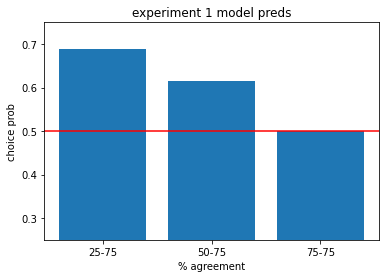

In [86]:
plt.figure()
plt.bar(['25-75', '50-75', '75-75'], results)
plt.ylim([0.25, 0.75])
plt.xlabel('% agreement')
plt.ylabel('choice prob')
plt.axhline(y=0.5, color='r', linestyle='-')
plt.title('experiment 1 model preds')
plt.show()

# Experiment 2

This time, you have four people, and you are trying to figure out their choices